# Installation

##### To run PyImageJ, please follow the Installation : https://pyimagej.readthedocs.io/en/latest/Install.html#installing-via-pip

- Install OpenJDK 8 or OpenJDK 11. https://docs.azul.com/core/zulu-openjdk/install/windows#install-azul-zulu-from-zip-or-tar-gz-package
- Install Maven. https://maven.apache.org/install.html#windows-tips
- Install pyimagej via pip : " pip install pyimagej "

- PyImageJ’s documentation : https://pyimagej.readthedocs.io/en/latest/index.html#

# Initialize PyImageJ

In [1]:
import imagej
import scyjava as sj # scyjava : Supercharged Java access from Python, see https://github.com/scijava/scyjava

# NOTE: The ImageJ2 gateway is initialized through a Java Virtual Machine (JVM). If you want to configure the JVM, it must be done before initializing an ImageJ2 gateway.
# sj.config.add_option('-Xmx10g') # adjust memory available to Java

In [2]:
Fiji_Local = r"C:\Users\confocal_microscope\Desktop\Tools\Fiji.app"

# ij = imagej.init(Fiji_Local) # Same as "ij = imagej.init(Fiji_Local, mode='headless')", PyImageJ’s default mode is headless
# ij = imagej.init(Fiji_Local, mode='gui') # GUI mode (會卡在這一行 -> blocking), for more explainations : https://pyimagej.readthedocs.io/en/latest/Initialization.html#gui-mode
ij = imagej.init(Fiji_Local, mode='interactive') # Interactive mode (可以繼續向下執行 -> non-blocking), for more explainations : https://pyimagej.readthedocs.io/en/latest/Initialization.html#interactive-mode
# ij.ui().showUI() # if you want to display the GUI immediately

print(ij.getApp().getInfo(True))

ImageJ2 2.9.0/1.54b; Java 1.8.0_362 [amd64]; 62MB of 9102MB


In [3]:
def dump_info(image, CLI_print_title:str=None):
    """A handy function to print details of an image object."""
    name = image.name if hasattr(image, 'name') else None # xarray
    if name is None and hasattr(image, 'getName'): name = image.getName() # Dataset
    if name is None and hasattr(image, 'getTitle'): name = image.getTitle() # ImagePlus
    
    if CLI_print_title is not None: print(f"--> {CLI_print_title}:\n")
    print(f"    name  : {name or 'N/A'}")
    print(f"    type  : {type(image)}")
    print(f"    dtype : {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
    print(f"    shape : {image.shape if hasattr(image, 'shape') else 'N/A'}")
    print(f"    dims  : {image.dims if hasattr(image, 'dims') else 'N/A'}\n")

# Python code cooperate with ImageJ

In [4]:
import os
import sys

import xarray
import cv2

## 6 Working with Images

### File I/O

- Load file --> ```ij.io().open( [input_path: str] )```
- Save file --> ```ij.io().save( [image: java_class], [output_path: str] )```

### Displaying images with PyImageJ

PyImageJ has two primary ways of displaying images after they have been loaded:

ImageJ's image viewer ( ```ij.ui().show()``` )
  - Java
  - Supports n-dimensional image data
  - Only available when PyImageJ is initialized in interactive mode or gui mode for MacOS users

matplotlib's pyplot ( ```ij.py.show()``` )
  - Python
  - Supports 2D image data (e.g. X and Y only)

### Example: Load, Display, and Save

In [5]:
TIF_FILE = r"C:\Users\confocal_microscope\Desktop\PyImageJ-test-data\20220628_CE006_palmskin_8dpf - Series006_fish_68_P_RGB.tif"
WEB_FILE = "https://wsr.imagej.net/images/Cell_Colony.jpg"

# Load image

fish_68_P_RGB = ij.io().open(TIF_FILE)
web_image = ij.io().open(WEB_FILE)

ij.ui().show(fish_68_P_RGB)
ij.ui().show(web_image)

# You can save your data with ij.io().save(image, filepath) to save your image data to disk.

desktop_path = r"C:\Users\confocal_microscope\Desktop\PyImageJ-test-data"
file_name = r"saved_web_image.tiff"
out_path = os.path.join(desktop_path, file_name)

ij.io().save(web_image, out_path)

[java.lang.Enum.toString] [INFO] Populating metadata


### Data conversion between Java and Python

Python -> Java : ```ij.py.to_java(``` [ image: Python_class ] ```)```

  - Wraps the image **without making a copy**. This means that you can modify the original NumPy array values, and the same changes will **automatically be reflected** on the Java side as well.

Java -> Python : ```ij.py.from_java(``` [ image: Java_class ] ```)```

  - **Metadata-rich** images such as Dataset become **xarrays**.
  - Plain **metadata-free** images (e.g. Img, RandomAccessibleInterval) become **NumPy array**s.

Direct image converters: ```to_dataset()```, ```to_img()```, ```to_imageplus()``` and ```to_xarray()```

  - ```ImagePlus``` is a class while reading an image using ```ij.IJ.openImage()``` ( original ImageJ command )
  - accept both Java and Python image objects (e.g. net.imagej.Dataset, numpy.ndarray, xarray.DataArray, ij.ImagePlus, etc…)
  - optionaly a ```dim_order``` (a list of dimensions as strings) keyword argument. The ```dim_order``` option can be used by a direct image converter to poperly shuffle the dimensions into their expected positions, usage : ```ij.py.to_dataset( [ image: Java_class ] , dim_order=['row', 'col', 'ch'])```


*Note* : ```scikit-image``` has defined conventions for the **order of dimensions** as follows: ```(t, pln, row, col, ch)```, and ```PyImageJ``` makes an effort to respect the scikit-image dimension order convention where applicable, including **reordering dimensions between ImageJ2 style and scikit-image style** when translating images between worlds, i.e. ```XYCZT``` will reorder in shape ```(t, pln, row, col, ch)``` by default when doing a conversion, vice versa.

- ```t``` is time, ```pln``` is plane/Z, ``row`` is row/Y, ```col``` is column/X, and ```ch``` is channel.

- RGB images as NumPy arrays do not have any **axes** or **dimension metadata** and get mangled during the conversion process to an ImageJ Java object (like a ```net.imagej.Dataset```). This is because the PyImageJ’s default behavior for converting images without axes/dimension information is to assume a general ```(t, pln, row, col, ch)```organization to the data and inverts the order. An RGB image with shape ```(100, 250, 3)``` converted to a ```net.imagej.Dataset``` without dimension order information will return with shape ```(3, 250, 100)```. Attempting to display this in ImageJ’s viewer will produce crazy results as ImageJ expects the first two dimensions to be ```X``` and ```Y```. But in this case the first two dimensions are ```Channel``` and ```Y```! This can be resolved by performing the same image conversion but with a ```dim_order=['row', 'col', 'ch']```.

In [6]:
dump_info(fish_68_P_RGB, "'fish_68_P_RGB' read by ij.io().open()")
dump_info(web_image, "'web_image' read by ij.io().open()")

# convert the ImageJ image (Java) to an xarray.DataArray (Python)
xarr_fish_68_P_RGB = ij.py.from_java(fish_68_P_RGB)
xarr_web_image = ij.py.from_java(web_image)

# dump info on xarray.DataArray result from ij.py.from_java()
dump_info(xarr_fish_68_P_RGB, "'fish_68_P_RGB' convert Java to Python")
dump_info(xarr_web_image, "'web_image' convert Java to Python")


cv_fish_68_P_RGB = cv2.imread(TIF_FILE) # ch. orient : BGR
dump_info(cv_fish_68_P_RGB, "'cv_fish_68_P_RGB' read by cv2.imread()")

j_cv_fish_68_P_RGB = ij.py.to_imageplus(cv_fish_68_P_RGB)
dump_info(j_cv_fish_68_P_RGB, "'cv_fish_68_P_RGB' convert Python to Java ( without dims label, the result is crazy )")
# ij.ui().show(j_cv_img)

x_cv_fish_68_P_RGB = xarray.DataArray(cv_fish_68_P_RGB, name=TIF_FILE.split(os.sep)[-1], dims=('row', 'col', 'ch'))
x_cv_fish_68_P_RGB = x_cv_fish_68_P_RGB[:, :, ::-1] # BGR --> RGB
dump_info(x_cv_fish_68_P_RGB, "'x_cv_fish_68_P_RGB' with dims label (xarray)")
j_cv_fish_68_P_RGB = ij.py.to_java(x_cv_fish_68_P_RGB)
dump_info(j_cv_fish_68_P_RGB, "'x_cv_fish_68_P_RGB' convert Python to Java ( with dims label, the result is correct )")
# ij.ui().show(j_cv_fish_68_P_RGB)

--> 'fish_68_P_RGB' read by ij.io().open():

    name  : 20220628_CE006_palmskin_8dpf - Series006_fish_68_P_RGB.tif
    type  : <java class 'net.imagej.DefaultDataset'>
    dtype : <java class 'net.imglib2.type.numeric.integer.UnsignedByteType'>
    shape : (1024, 1024, 3)
    dims  : ('X', 'Y', 'Channel')

--> 'web_image' read by ij.io().open():

    name  : saved_web_image.tiff
    type  : <java class 'net.imagej.DefaultDataset'>
    dtype : <java class 'net.imglib2.type.numeric.integer.UnsignedByteType'>
    shape : (406, 408)
    dims  : ('X', 'Y')

--> 'fish_68_P_RGB' convert Java to Python:

    name  : 20220628_CE006_palmskin_8dpf - Series006_fish_68_P_RGB.tif
    type  : <class 'xarray.core.dataarray.DataArray'>
    dtype : uint8
    shape : (1024, 1024, 3)
    dims  : ('row', 'col', 'ch')

--> 'web_image' convert Java to Python:

    name  : saved_web_image.tiff
    type  : <class 'xarray.core.dataarray.DataArray'>
    dtype : uint8
    shape : (408, 406)
    dims  : ('row', '

### Slicing Java and Python images

In [7]:
# Java Dataset
Red = fish_68_P_RGB[:,:,0] # split ch. Red
Red = ij.py.to_dataset(Red)
Red.setName("Red")
dump_info(Red, "Split Red Channel from 'fish_68_P_RGB'")
ij.ui().show(Red)

# Python Xarray
Red = x_cv_fish_68_P_RGB[:,:,0] # split ch. Red
Red.name = "Red"
Red = ij.py.to_java(Red)
dump_info(Red, "Split Red Channel from 'x_cv_fish_68_P_RGB'")
ij.ui().show(Red)


--> Split Red Channel from 'fish_68_P_RGB':

    name  : Red
    type  : <java class 'net.imagej.DefaultDataset'>
    dtype : <java class 'net.imglib2.type.numeric.integer.UnsignedByteType'>
    shape : (1024, 1024)
    dims  : ('X', 'Y')

--> Split Red Channel from 'x_cv_fish_68_P_RGB':

    name  : Red
    type  : <java class 'net.imagej.DefaultDataset'>
    dtype : <java class 'net.imglib2.type.numeric.integer.UnsignedByteType'>
    shape : (1024, 1024)
    dims  : ('X', 'Y')



## 7 Running macros, scripts and plugins

### 7.3 Example: Run a plugin:

img["blobs.gif" (-9), 8-bit, 256x254x1x1x1] 

    name  : blobs.gif
    type  : <java class 'ij.ImagePlus'>
    dtype : N/A
    shape : (256, 254)
    dims  : ('X', 'Y')



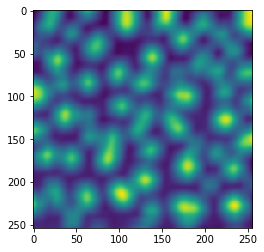

In [8]:
ij.py.run_macro("""run("Blobs (25K)");""")
blobs = ij.WindowManager.getCurrentImage()
print(blobs, "\n")
dump_info(blobs)

# NB: This is not a built-in ImageJ command! It is the
# Plugins › Integral Image Filters › Mean command,
# which is part of mpicbg_, which is included with Fiji.
plugin = 'Mean'
args = { 
    'block_radius_x': 10,
    'block_radius_y': 10
}
ij.py.run_plugin(plugin, args)

result = ij.WindowManager.getCurrentImage()
result = ij.py.show(result)

In [9]:
print(ij.WindowManager.getCurrentImage()) # obtain the current (focused) image from the WindowManager
print(ij.window().getOpenWindows()) # list all active original ImageJ windows
ij.window().clear() # Note: 不會關閉已經開啟的視窗

None
[null]


## 8 Discover ImageJ commands with the Recorder 

### 8.1 Example 1: Apply “Find Maxima…” command to an image

- The “Find Maxima…” command will overlay detections ontop of a displayed input image, therefore we will need to initialize ImageJ in **interactive** mode. ( MacOS : gui mode )
- Because the “Find Maxima…” and other original ImageJ commands work with the ImagePlus object type (instead of the newer ImageJ2/ImgLib2 ```Dataset``` and ```ImgPlus``` object types) we need to first convert the ```Dataset``` returned from ```ij.io().open()``` to an ```ImagePlus```.

--> imp_still : Dataset to ImagePlus:

    name  : test_still.tif
    type  : <java class 'ij.ImagePlus'>
    dtype : N/A
    shape : (300, 300)
    dims  : ('X', 'Y')



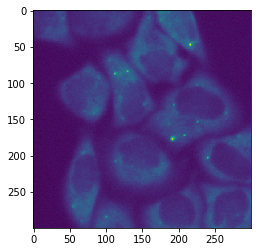

In [68]:
# open test image and convert from Dataset to ImagePlus
imp_still = ij.io().open(r"C:\Users\confocal_microscope\Desktop\PyImageJ-test-data\test_still.tif")
imp_still = ij.py.to_imageplus(imp_still)
dump_info(imp_still, "imp_still : Dataset to ImagePlus")

# show the "ImagePlus" image

# Matplotlib
ij.py.show(imp_still)

# ImageJ's viewer
#WARNING: Don not use "ij.ui().show(imp)" and "imp.show()" at same time
imp_still.getProcessor().resetMinAndMax()
ij.ui().show(imp_still)
# imp_still.show() # "ImagePlus" only

ij.IJ.run(imp_still, "Find Maxima...", "prominence=1000 output=[Point Selection]")

### 8.2 Example 2: Extract a slice and run “Analyze Particles…”

In [ ]:
# import imagej
# import scyjava as sj 


# def dump_info(image, CLI_print_title:str=None):
#     """A handy function to print details of an image object."""
#     name = image.name if hasattr(image, 'name') else None # xarray
#     if name is None and hasattr(image, 'getName'): name = image.getName() # Dataset
#     if name is None and hasattr(image, 'getTitle'): name = image.getTitle() # ImagePlus
    
#     if CLI_print_title is not None: print(f"--> {CLI_print_title}:\n")
#     print(f"    name  : {name or 'N/A'}")
#     print(f"    type  : {type(image)}")
#     print(f"    dtype : {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
#     print(f"    shape : {image.shape if hasattr(image, 'shape') else 'N/A'}")
#     print(f"    dims  : {image.dims if hasattr(image, 'dims') else 'N/A'}\n")



# # initialize ImageJ
# # ij = imagej.init('sc.fiji:fiji:2.9.0')
# ij = imagej.init('sc.fiji:fiji:2.9.0', mode='interactive')
# print(f"ImageJ version: {ij.getVersion()}")


# get ImageJ's duplicator
Duplicator = sj.jimport('ij.plugin.Duplicator')

# run ImageJ commands
imp_timeseries = ij.IJ.openImage(r"C:\Users\confocal_microscope\Desktop\PyImageJ-test-data\test_timeseries.tif")
dump_info(imp_timeseries, "'imp_timeseries' read by ij.IJ.openImage()")
ij.ui().show(imp_timeseries)

imp_extract = Duplicator().run(imp_timeseries, 3, 3, 1, 1, 14, 14) # visit the Javadoc for more info https://imagej.nih.gov/ij/developer/api/ij/ij/plugin/Duplicator.html
ij.IJ.run(imp_extract, "Enhance Contrast", "saturated=0.35")
ij.ui().show(imp_extract)
ij.IJ.setAutoThreshold(imp_extract, "Moments dark")
ij.IJ.run(imp_extract, "Analyze Particles...", " show=Overlay display clear")

## 10 Using ImageJ Ops

In [16]:
[op for op in ij.op().ops() if "tube" in op]

['filter.tubeness']

In [17]:
ij.op().help("filter.tubeness")

'Available operations:
	(IterableInterval out?) =
	net.imagej.ops.filter.tubeness.DefaultTubeness(
		IterableInterval out?,
		RandomAccessibleInterval in,
		double sigma,
		double[] calibration)'

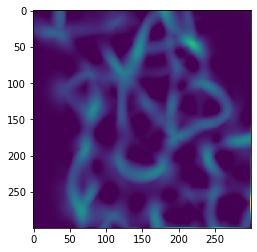

In [18]:
# run tubeness op with ij.op().run()
def tubeness_1(image, sigma, calibration=[]):
    return ij.op().run("filter.tubeness", ij.py.jargs(image, sigma, calibration))

image_1 = ij.io().open(r"C:\Users\confocal_microscope\Desktop\PyImageJ-test-data\test_still.tif")
ij.py.show(tubeness_1(image_1, sigma=10))

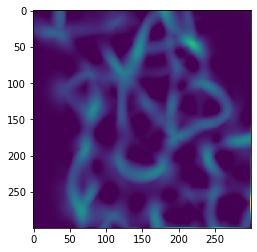

In [19]:
# run tubeness op with filter namespace
def tubeness_2(image, sigma, calibration=[]):
    return ij.op().filter().tubeness(image, sigma, calibration)

image_2 = ij.io().open(r"C:\Users\confocal_microscope\Desktop\PyImageJ-test-data\test_still.tif")
ij.py.show(tubeness_2(image_2, sigma=10))

In [20]:
import ipywidgets

def recalc(**kwargs):
    ij.py.show(tubeness_1(image_1, kwargs['sigma']), cmap='magma')
sigma_slider = ipywidgets.IntSlider(description="sigma", min=1, max=20, value=10, continuous_update=True)
ipywidgets.interact(recalc, sigma=sigma_slider)

interactive(children=(IntSlider(value=10, description='sigma', max=20, min=1), Output()), _dom_classes=('widge…

<function __main__.recalc(**kwargs)>

## 11 Working with the original ImageJ

### 11.2 One ImageJ-enabled gateway at a time

ImageJ was not designed to run multiple simultaneous instances in the same JVM, whereas ImageJ2 supports multiple gateways at once.

In [ ]:
def legacy_status(gateway):
    print(f" legacy service: {gateway.legacy}")
    print(f"  legacy active? {gateway.legacy and gateway.legacy.isActive()}")
    print(f"ImageJ2 version: {gateway.getVersion()}")

another_ij = imagej.init()
print("[ij - the original gateway]")
legacy_status(ij)
print("\n[another_ij - a second gateway we constructed just now]")
legacy_status(another_ij)

### 11.5 Keeping image data in syce with ```ij.py.sync_image(imp)```

--> skin : xarray.DataArray():

    name  : skin
    type  : <class 'xarray.core.dataarray.DataArray'>
    dtype : uint8
    shape : (960, 1280, 3)
    dims  : ('row', 'col', 'ch')

--> skimp : to_imageplus():

    name  : skin
    type  : <java class 'ij.CompositeImage'>
    dtype : N/A
    shape : (1280, 960, 3)
    dims  : ('X', 'Y', 'C')

--> skimp : to_dataset():

    name  : skin
    type  : <java class 'net.imagej.DefaultDataset'>
    dtype : <java class 'net.imglib2.type.numeric.integer.UnsignedByteType'>
    shape : (1280, 960, 3)
    dims  : ('X', 'Y', 'Channel')

skin: [219, 217, 211, 219, 217, 211, 220, 215, 211]
skimp: [219, 217, 211, 219, 217, 211, 220, 215, 211]


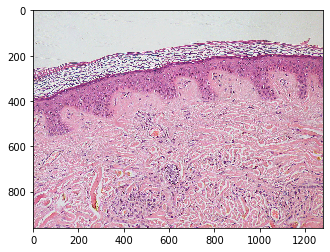

In [71]:
import skimage, xarray

skin = xarray.DataArray(skimage.data.skin(), name='skin', dims=('row', 'col', 'ch'))
skimp = ij.py.to_imageplus(skin)
skinds = ij.py.to_dataset(skin)

dump_info(skin, "skin : xarray.DataArray()")
dump_info(skimp, "skimp : to_imageplus()")
dump_info(skinds, "skinds : to_dataset()")


def print_3x3_corner():
    print(f"skin: {[int(skin[y,x,0]) for x in range(3) for y in range(3)]}")
    print(f"skimp: {[skimp.getPixel(x,y)[0] for x in range(3) for y in range(3)]}")
print_3x3_corner()

ij.py.show(skin)

In [72]:
skimp.getProcessor().set(17)
assert skimp.getPixel(0,0)[0] == 17

skin: [219, 217, 211, 219, 217, 211, 220, 215, 211]
skimp: [17, 17, 17, 17, 17, 17, 17, 17, 17]


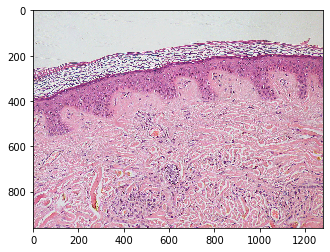

In [73]:
print_3x3_corner()
ij.py.show(skin)

In [74]:
# sync the ImagePlus to update the backing NumPy array
ij.py.sync_image(skimp)

skin: [17, 17, 17, 17, 17, 17, 17, 17, 17]
skimp: [17, 17, 17, 17, 17, 17, 17, 17, 17]


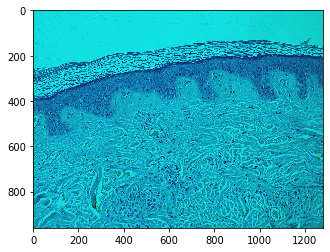

In [75]:
print_3x3_corner()
ij.py.show(skin)
ij.ui().show(skimp)